# Classify MNIST digits using Multilayer Perceptron - CNTK

Exploring CNTK machine learning/ deep learning capability with MNIST dataset.

In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import cntk as C

In [3]:
path= "data\MNIST"

# Data I/O
We need to read the data into CNTK data structure format. First, let's get the shapes of input data and label. Then, locate data files as well.

In [4]:
nb_input = 60000
input_size = 28*28
label_size = 10

In [5]:
train_file = os.path.join(path, "Train-28x28_cntk_text.txt")
valid_file = os.path.join(path, "Test-28x28_cntk_text.txt")

Modern machine learning uses mini-batch gradient descent optimization algorithms, therefore, it requires a procedure to stream mini-batch into the model being trained. CNTK provides methods to do this, though, it is a little bit complicated. 

In [6]:
labelStream = C.io.StreamDef(field='labels', shape=label_size, is_sparse=False)
featureStream = C.io.StreamDef(field='features', shape=input_size, is_sparse=False)

In [7]:
train_deserailizer = C.io.CTFDeserializer(train_file, C.io.StreamDefs(labels = labelStream, features = featureStream))
valid_deserailizer = C.io.CTFDeserializer(valid_file, C.io.StreamDefs(labels = labelStream, features = featureStream))

Now, we define the train and test data loadder to feed to training and testing models. The only difference is during training we will randomize the data loading process and we can load the entire dataset multiple times (many epochs). Whereas, we only load the test data once and we do not need to ramdomize it.

In [8]:
train_loader = C.io.MinibatchSource(train_deserailizer,randomize = True, max_sweeps = C.io.INFINITELY_REPEAT)
valid_loader = C.io.MinibatchSource(valid_deserailizer,randomize = False, max_sweeps = 1)

# Building model

### Input variables

In CNTK, an input varibale is a placeholder in which data will be filled. The input varibales should be defined for all data, i.e., input and labels in the case of supervised learning. The input varibale in CNTK is similar to the placeholder in tensorFlow.

For the MNIST problems, there are 2 CNTK input variables: flatten image pixels of the size 28x28 and the label of the size 10.


**Note** We will normalized the gray-scale values of the pixel (ranging 0-255) to the range of 0-1. This is a common practice in machine learning, especially useful in the context of neural networks since we will later use activation functions such as sigmoid or softmax. Because these functions essentially squash the input value and output values between 0 and 1, very big input values are not prefer.

In [9]:
input_var = C.input_variable(input_size) 
label = C.input_variable(label_size)

## 2.1 A Multilayer Perceptron Model

### 2.1.1 Model creation

The design of multilayer perceptron model consists of specifying number of hidden (dense or fully connected) layers, size of each hidden layer, activation functions in hidden layers. 

In [10]:
nb_dense_layers = 3
dense_layer_size = [300, 400, 500]

In [11]:
def MLP_model(data, nb_dense_layers, dense_layer_size, output_size):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.ops.relu):
        input = data
        for i in range(nb_dense_layers):
            input = C.layers.Dense(dense_layer_size[i])(input)
        output = C.layers.Dense(output_size, activation = None)(input)
        return output

In [12]:
MLP_Model = MLP_model(input_var/225, nb_dense_layers, dense_layer_size, label_size) # Normalize the input to 0-1

Now, take a look into the output object.

In [13]:
print(MLP_Model)

Composite(Tensor[784]) -> Tensor[10]


In [14]:
MLP_Model.parameters

(Parameter('W', [], [500 x 10]),
 Parameter('b', [], [10]),
 Parameter('W', [], [400 x 500]),
 Parameter('b', [], [500]),
 Parameter('W', [], [300 x 400]),
 Parameter('b', [], [400]),
 Parameter('W', [], [784 x 300]),
 Parameter('b', [], [300]))

We can see the parameters of the model, which will be learned, includes 4 weight matrices W of the size 784x300, 300x400, 400x500, 500x10 and bias vectors b of the size 300, 400, 500, 10, respectively. This is exactly the body part of a logistic regression model. 

To have a full multilayer perceptron model, we will squash the output to probabilities, i.e., to output values between 0 and 1 using softmax activation layer.

### 2.1.2 Multilayer perceptron loss function

In CNTK, softmax and cross-entropy are combined into a function called *cross_entropy_with_softmax*.

In [15]:
MLP_loss = C.cross_entropy_with_softmax(MLP_Model, label)

We also record the classification error between output and label (ground truth) during training.

In [16]:
MLP_error = C.classification_error(MLP_Model, label)

### 2.1.3 Setup training parameters
Next, we will plan out our training. In particular, we need to set the following hyperparameters:

- A learning rate schedule: this is the learning rate profile used during training, we can set it to be uniform (constant) all the time or let the learning rate decay exponentially.
- An optization algorithm: the logistic regression model is based on maximum likelihood pricipal, hence, an optimzation mechanism is needed.
- Minibatch size: to speed up the learning process, we will not optimize the entire data batch once but divide it into small batches. Thus, we need to define how many data points we will load each time, i.e., minibatch size.
- Number of epochs: how many time we want to pass the entire input dataset through the model.


In [17]:
lr = 0.3
lr_schedule = C.learning_rate_schedule(lr, C.UnitType.minibatch)

In [18]:
learner = C.sgd(MLP_Model.parameters, lr_schedule)
trainer = C.Trainer(MLP_Model, (MLP_loss, MLP_error), [learner])

Here, in CNTK, 

- learner is an object that holds all the hyperparemeters neccessary in training process. It contains information about the weights and biases to be learned, the learning rate, the optimzation algorithms in this case, the stochastic gradient descent.

- trainer is another CNTK object that will lay out how the training process will be done. It contains the model used, e.g., multi-class logistic regression, the loss function to optimize, the error to record, and all the information of the learner.


In [19]:
minibatch_size = 128
nb_epoch = 10

We will create a loop to pass all the minibatch to the trainer, hence, we need to calculate how many total number minibatch we will process.

In [20]:
nb_batches = round((nb_input*nb_epoch)/minibatch_size)
nb_batches

4688

### 2.1.4 Training
Now, we are ready to proceed training.

In [21]:
def fit_data(trainer, minibatch_size, nb_batches, input_dict, print_frequency, verbose = True):
    train_history = {"minibatch":[], "loss":[], "error":[]}
    for batch_number in range(nb_batches):
        data = train_loader.next_minibatch(minibatch_size, input_map = train_dict)
        trainer.train_minibatch(data)        
        if (batch_number % print_frequency == 0) : # Time to print some result
            loss = trainer.previous_minibatch_loss_average
            error = trainer.previous_minibatch_evaluation_average
            if verbose:
                print("Current minibatch: {}, loss: {}, error: {}".format(batch_number, loss, error*100))
            train_history["minibatch"].append(batch_number)
            train_history["loss"].append(loss)
            train_history["error"].append(error)
    return train_history

In [24]:
train_loader = C.io.MinibatchSource(train_deserailizer,randomize = True, max_sweeps = C.io.INFINITELY_REPEAT)
train_dict = {label : train_loader.streams.labels, input_var : train_loader.streams.features}

In [25]:
train_history= fit_data(trainer, minibatch_size, nb_batches, train_dict, print_frequency = 500, verbose = True)

Current minibatch: 0, loss: 2.281973361968994, error: 85.9375
Current minibatch: 500, loss: 0.1339631825685501, error: 4.6875
Current minibatch: 1000, loss: 0.03303167223930359, error: 0.78125
Current minibatch: 1500, loss: 0.007529988884925842, error: 0.0
Current minibatch: 2000, loss: 0.01985211670398712, error: 0.78125
Current minibatch: 2500, loss: 0.0038940906524658203, error: 0.0
Current minibatch: 3000, loss: 0.0034787505865097046, error: 0.0
Current minibatch: 3500, loss: 0.02382742241024971, error: 0.78125
Current minibatch: 4000, loss: 0.004933331161737442, error: 0.0
Current minibatch: 4500, loss: 0.0014215484261512756, error: 0.0


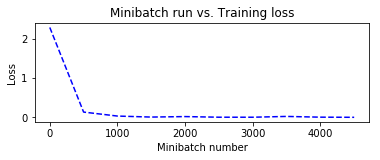

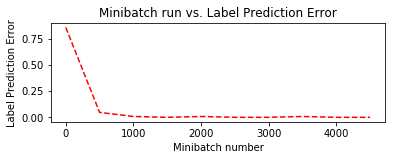

In [26]:
plt.figure(1)
plt.subplot(211)
plt.plot(train_history["minibatch"], train_history["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(train_history["minibatch"], train_history["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

As shown, the training curve is bumpy but the general trend is downward, this is due to minibatch training. We can visualize the training process better by running the loss and error data through a moving avarage filter. It will smooth out the curve.

### 2.2.5 Validation

In [27]:
def evaluate(trainer, valid_sample_size):
    result = 0.0
    valid_loader = C.io.MinibatchSource(valid_deserailizer,randomize = False, max_sweeps = 1)
    valid_dict = {label : valid_loader.streams.labels, input_var : valid_loader.streams.features}
    for image in range(valid_sample_size):
        data = valid_loader.next_minibatch(1, input_map = valid_dict)
        valid_error = trainer.test_minibatch(data)        
        result += valid_error
    average_result = result * 100.0/valid_sample_size
    print("average validation error: {0:.2f}% ".format(average_result))
    return average_result

In [28]:
valid_sample_size = 10000

In [29]:
valid_error = evaluate(trainer, valid_sample_size)

average validation error: 1.98% 


We got a validation error rate around 2%. Let's check some images.

In [30]:
valid_loader = C.io.MinibatchSource(valid_deserailizer,randomize = False, max_sweeps = 1)
valid_dict = {label : valid_loader.streams.labels, input_var : valid_loader.streams.features}

In [31]:
valid_sample = valid_loader.next_minibatch(30, input_map = valid_dict)

In [32]:
labels = valid_sample[label].asarray()
images = valid_sample[input_var].asarray()

In [35]:
pred = [np.argmax(C.softmax(MLP_Model).eval(images[i])) for i in range(30)]
true_label = [np.argmax(labels[i]) for i in range(30)]

In [36]:
print("Label    :", true_label)
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1]


Predicted Label:  0


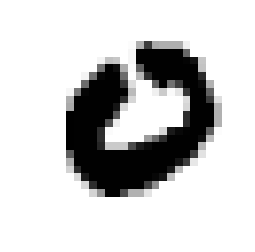

In [38]:
sample = 25
plt.imshow(images[sample].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_pred = pred[sample]
print("Predicted Label: ", img_pred)